In [1]:
import torch 
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split #delete
from torchvision.transforms import Lambda
import numpy as np
from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
import warnings

print("You are using:")
!python --version
print(f"{torch.__version__=}")
print("MPS support=", torch.backends.mps.is_available())
if torch.backends.mps.is_available():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)


You are using:
Python 3.13.1
torch.__version__='2.6.0'
MPS support= True
Using device: mps


In [2]:
import os 
import glob 
from PIL import Image

dataset_dir = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/images"

img_paths = glob.glob(os.path.join(dataset_dir, "*", "*.jpg"))
attribute4image_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/attributes/image_attribute_labels.txt"
attributes_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/attributes/attributes.txt"
class_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/classes.txt"
labels4image_path = "/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/image_class_labels.txt"
images_names = '/Users/niccolozenaro/Università/Machine Learning/CUB_200_2011/images.txt'

labels4image = pd.read_csv(labels4image_path, sep=' ', header=None)
classnames = pd.read_csv(class_path, sep=' ', header=None)

images_dict = {} #dictionary with image name and id

with open(images_names, 'r') as f:
    for line in f:
        img_ID, img_foldername = line.strip().split()
        img_name = img_foldername.split('/')[1]
        images_dict[img_name] = int(img_ID)
   

In [3]:
#modify imagefolder to include the IDs

class ImageFolderWithIDs(ImageFolder):
    def __init__(self, root, transform=None, id_map=images_dict):
        super().__init__(root, transform)
        self.id_map = id_map

    def __getitem__(self, index):

        img, label = super().__getitem__(index)

        img_path, _ = self.samples[index]
        img_filename = os.path.basename(img_path)

        image_id = self.id_map[img_filename]
        label += 1

        return img, label, image_id
       

In [4]:
#load the dataset
dataset = ImageFolderWithIDs(dataset_dir, transform=None, id_map=images_dict)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.ToTensor()
    ])
other_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

classes = sorted(np.unique(dataset.targets))
print(f"Number of Classes: {len(classes)}")
print(f"Dataset shape before splitting: {len(dataset)}")

label_count = {}

for _, label, img_id in dataset:
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1

print(label_count)

train_data, test_data, val_data = random_split(dataset, [0.75, 0.2, 0.05] )
print(f"Dataset shape after splitting: training={len(train_data)}, testing={len(test_data)}, validation={len(val_data)}")

train_data.dataset.transform = train_transform
val_data.dataset.transform = other_transform
test_data.dataset.transform = other_transform

Number of Classes: 200
Dataset shape before splitting: 11788
{1: 60, 2: 60, 3: 58, 4: 60, 5: 44, 6: 41, 7: 53, 8: 48, 9: 59, 10: 60, 11: 60, 12: 56, 13: 60, 14: 60, 15: 58, 16: 58, 17: 57, 18: 45, 19: 59, 20: 59, 21: 60, 22: 56, 23: 59, 24: 52, 25: 60, 26: 60, 27: 60, 28: 59, 29: 60, 30: 60, 31: 60, 32: 53, 33: 59, 34: 59, 35: 60, 36: 60, 37: 59, 38: 60, 39: 59, 40: 60, 41: 60, 42: 60, 43: 59, 44: 60, 45: 60, 46: 60, 47: 60, 48: 60, 49: 60, 50: 60, 51: 60, 52: 60, 53: 60, 54: 60, 55: 60, 56: 60, 57: 60, 58: 58, 59: 60, 60: 59, 61: 60, 62: 60, 63: 60, 64: 60, 65: 50, 66: 60, 67: 60, 68: 60, 69: 60, 70: 60, 71: 60, 72: 60, 73: 60, 74: 60, 75: 57, 76: 60, 77: 60, 78: 59, 79: 60, 80: 60, 81: 60, 82: 60, 83: 60, 84: 53, 85: 60, 86: 60, 87: 60, 88: 60, 89: 60, 90: 60, 91: 60, 92: 60, 93: 60, 94: 60, 95: 60, 96: 60, 97: 59, 98: 60, 99: 60, 100: 60, 101: 50, 102: 60, 103: 60, 104: 60, 105: 49, 106: 60, 107: 59, 108: 60, 109: 60, 110: 60, 111: 60, 112: 60, 113: 50, 114: 60, 115: 59, 116: 60, 11

In [5]:
#load the attributes
attributes = torch.zeros(len(dataset), 312)

with open (attribute4image_path, 'r') as f:
    for line in f:
        value = line.strip().split()
        img_ID, att_ID, is_present = value[:3]
        attributes[int(img_ID)-1, int(att_ID)-1] = int(is_present)



In [6]:
#Create the dataloaders for each of them, batch size is set
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Image shape: 32, label: 153, img_id: 8986


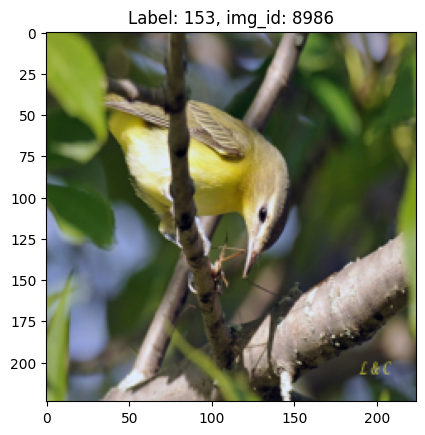

In [7]:
for img, label, img_id in train_loader:
    print(f"Image shape: {img.shape[0]}, label: {label[0]}, img_id: {img_id[0]}")

    image = img[0].numpy().transpose(1, 2, 0)
    image = np.clip(image, 0, 1)

    plt.imshow(image)
    plt.title(f"Label: {label[0]}, img_id: {img_id[0]}")
    plt.show()
    break

In [8]:
from torchvision.models import resnet50, ResNet50_Weights

In [9]:
RESNET = resnet50(pretrained=True)
#model_graph = draw_graph(RESNET101, (torch.randn(1, 3, 224, 224)), device=device, expand_nested=True)
#model_graph.visual_graph
summary(RESNET, (32, 3, 224, 224), device=device)


/Users/niccolozenaro/Università/Machine Learning/MachineLearningProject/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/niccolozenaro/Università/Machine Learning/MachineLearningProject/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [12]:
#fine-tuning the model

class ResNet50AttributesTuned(nn.Module):
    def __init__(self, num_attributes, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True):
        super(ResNet50AttributesTuned, self).__init__()

        self.resnet = resnet50(weights=weights)

    #finetune only the last layer 
        if freeze_backbone:
            for name, param in self.resnet.named_parameters():
                if "layer4" in name or "fc" in name:
                    param.requires_grad = True
                else:
                    param.requires_grad = False

        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_attributes)

    def forward(self, x):
        return self.resnet(x)       

In [13]:
#training function
def train (model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)
    
    loss_train, loss_val = [], []
    acc_train, acc_val = [], []
    history1 = hl.History()
    canvas1 = hl.Canvas()

    for epoch in range(num_epochs):
        model.train()
        tot_acc_train, tot_count_train, n_train_batches, tot_loss_train = 0, 0, 0, 0

        for img, label, img_ID in train_loader:
            img = img.to(device)
            attribute = attributes[img_ID-1].to(device)
            optimizer.zero_grad()
            prediction = model(img)
            loss = criterion(prediction, attribute)

            tot_loss_train += loss.item()
            loss.backward()
            optimizer.step()

            tot_acc_train += ((prediction > 0.5).float() == attribute).sum().item()
            tot_count_train += attribute.size(0)
            n_train_batches += 1

        avg_loss_train = tot_loss_train / n_train_batches
        loss_train.append(avg_loss_train)
        accuracy_train = tot_acc_train / tot_count_train
        acc_train.append(accuracy_train)

        tot_acc_val, tot_count_val, n_val_batches, tot_loss_val = 0, 0, 0, 0

        with torch.no_grad():
            model.eval()
            for img, label, img_ID in val_loader:
                img = img.to(device)
                attribute = attributes[img_ID-1].to(device)
                prediction = model(img)
                loss = criterion(prediction, attribute)

                tot_loss_val += loss.item()

                tot_acc_val += ((prediction > 0.5).float() == attribute).sum().item()
                tot_count_val += attribute.size(0)
                n_val_batches += 1
        
        avg_loss_val = tot_loss_val / n_val_batches
        loss_val.append(avg_loss_val)
        accuracy_val = tot_acc_val / tot_count_val
        acc_val.append(accuracy_val)

        if epoch % 1 == 0:
            history1.log(epoch, train_loss = avg_loss_train, train_accuracy = accuracy_train, val_loss = avg_loss_val, val_accuracy = accuracy_val)
            with canvas1:
                canvas1.draw_plot([history1["train_loss"], history1["val_loss"]], labels=['Training Loss', 'Validation Loss'])
                canvas1.draw_plot([history1["train_accuracy"], history1["val_accuracy"]], labels=['Training Accuracy', 'Validation Accuracy'])

    return loss_train, acc_train, loss_val, acc_val

def plot_learning_acc_loss(loss_train, acc_train, loss_val, acc_val):
    
    plt.figure(figsize=(10, 12))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(len(acc_train)), acc_train, label="Training Accuracy")
    plt.plot(range(len(acc_val)), acc_val, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(len(loss_train)), loss_train, label="Training Loss")
    plt.plot(range(len(loss_val)), loss_val, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')

    plt.show()


In [14]:
num_epochs = 15
lr = 1e-3

model = ResNet50AttributesTuned(num_attributes=312, weights=ResNet50_Weights.IMAGENET1K_V1, freeze_backbone=True)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.resnet.fc.parameters(), lr=lr)

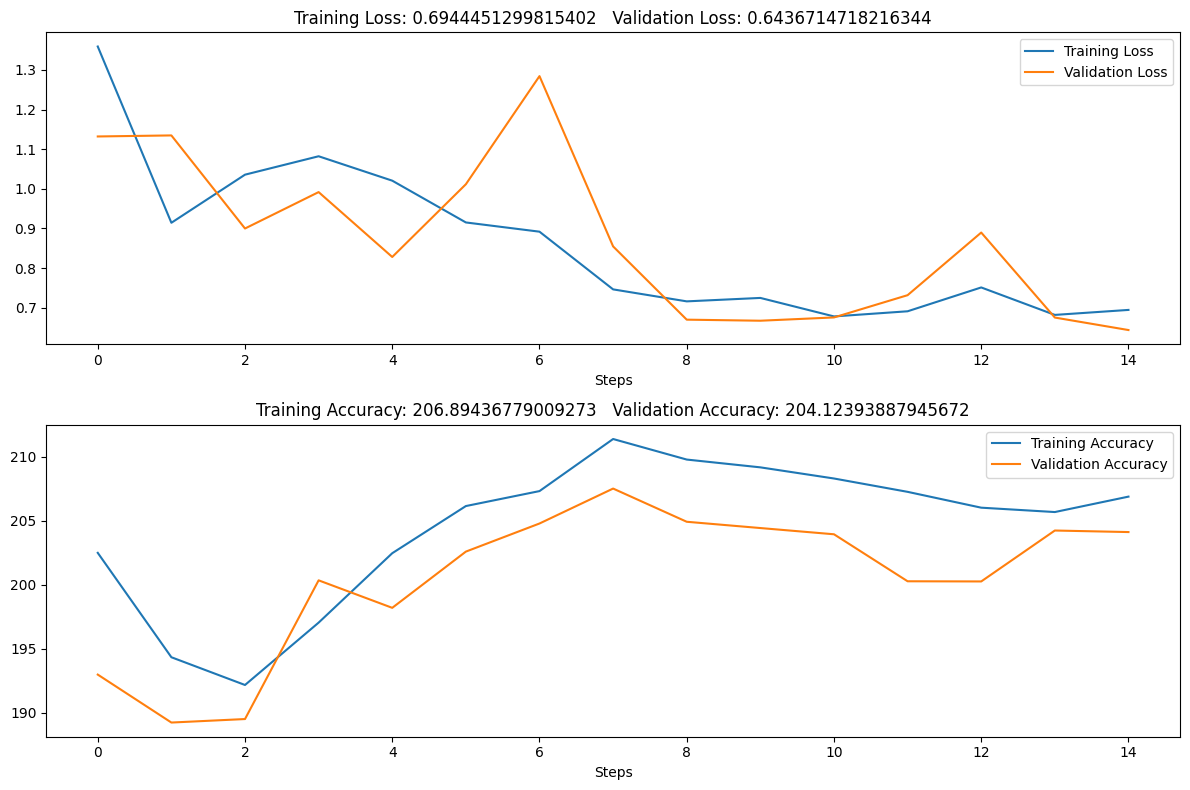

Training took 2169.25 seconds


In [15]:
start = timer()

loss_train, acc_train, loss_val, acc_val = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

end = timer()

print(f"Training took {end-start:.2f} seconds")

In [19]:
def test (model, dataloader_test = test_loader):
    model.eval()

    tot_acc, tot_count, n_batches, tot_loss = 0, 0, 0, 0
    for img, label, img_ID in dataloader_test:
        img = img.to(device)
        attribute = attributes[img_ID-1].to(device)
        prediction = model(img)
        tot_loss += criterion(prediction, attribute)
        tot_acc += ((prediction > 0.5).float() == attribute).sum().item()
        tot_count += attributes.size(0)
        n_batches += 1

    accuracy_test = tot_acc / tot_count
    loss_test = tot_loss / n_batches

    print(f"Test Loss: {loss_test:.4f}, Test Accuracy: {accuracy_test:.4f}")

In [20]:
test(model)

Test Loss: 0.6458, Test Accuracy: 0.5519
